<a href="https://colab.research.google.com/github/dTenebrae/neural_networks/blob/hw6/hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. 
2. Опишите  результат. Что помогло повысить точность?
 
3. *Попробуйте свои силы в задаче Carvana на Kaggle - https://www.kaggle.com/c/carvana-image-masking-challenge/overview4. 
4. *Сделайте свою реализацию U-Net на TensorFlow

In [ ]:
import os
import numpy as np
import pandas as pd 
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

from zipfile import ZipFile 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Работа с данными

def data_augmentation(car_img, mask_img):
    """
    Небольшая аугментация около половины картинок в датасете
    """
    # с вероятностью 1/2 делаем флип картинки и маски
    if tf.random.uniform(()) > 0.5:
        car_img = tf.image.flip_left_right(car_img)
        mask_img = tf.image.flip_left_right(mask_img)

    return car_img, mask_img

def preprocessing(car_path, mask_path, img_size=[256, 256]):
    """
    Нормируем и меняем размер
    """
    car_img = tf.io.read_file(car_path) 
    car_img = tf.image.decode_jpeg(car_img, channels=3)
    car_img = tf.image.resize(car_img, img_size)
    car_img = tf.cast(car_img, tf.float32) / 255.0
    
    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:,:,:1]    
    mask_img = tf.math.sign(mask_img)
    
    return car_img, mask_img

def create_dataset(df, train = False):
    """
    Запускаем препроцессинг, аугментацию и оборачиваем в датасет
    """
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df["car_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["car_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)

    return ds

In [ ]:
# Визуализация

def visualize(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask, img_size=[256, 256]):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, sample_mask, pred_mask])

In [ ]:
# Кастомные loss, metric, callback
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 2 == 0:
            show_predictions(sample_image, sample_mask)

In [ ]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        result.add(tf.keras.layers.ReLU())

    return result

def unet_model(output_channels):
    up_stack = [
                upsample(512, 3),  # 4x4 -> 8x8
                upsample(256, 3),  # 8x8 -> 16x16
                upsample(128, 3),  # 16x16 -> 32x32
                upsample(64, 3),   # 32x32 -> 64x64
                ]
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
def custom_unet_model(IMG_HEIGHT, IMG_WIDTH):
    in1 = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3 ))
    # initializer = tf.random_normal_initializer(0., 0.02)
    initializer = tf.keras.initializers.he_uniform()

    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(in1)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv4)

    up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(up1)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv5)
    
    up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(up2)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv6)

    up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(up2)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv7)
    segmentation = Conv2D(1, (1, 1), activation='sigmoid', name='seg')(conv7)

    unet_model = Model(inputs=[in1], outputs=[segmentation])

    return unet_model

___

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
clear_output()

In [ ]:
# не забыть смонтировать google drive, чтобы был доступ к токену
! mkdir ~/.kaggle && cp drive/MyDrive/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c carvana-image-masking-challenge
# clear_output()

mkdir: cannot create directory ‘/root/.kaggle’: File exists
carvana-image-masking-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# !unzip ./carvana-image-masking-challenge.zip

In [ ]:
!mkdir working
# распаковываем трейновый датасет
train_zip = "./train.zip"
with ZipFile(train_zip, 'r') as zip_: 
    zip_.extractall('./working')

mkdir: cannot create directory ‘working’: File exists


In [ ]:
# распаковываем маски
train_mask_zip = "./train_masks.zip"
with ZipFile(train_mask_zip, 'r') as zip_: 
    zip_.extractall('./working')

In [ ]:
print("Train set:  ", len(os.listdir("./working/train")))
print("Train masks:", len(os.listdir("./working/train_masks")))

Train set:   5088
Train masks: 5088


In [ ]:
car_ids = []
paths = []
for dirname, _, filenames in os.walk('./working/train'):
    for filename in filenames:
        path = os.path.join(dirname, filename)    
        paths.append(path)
        
        car_id = filename.split(".")[0]
        car_ids.append(car_id)

d = {"id": car_ids, "car_path": paths}
df = pd.DataFrame(data = d)
df = df.set_index('id')

In [ ]:
car_ids = []
mask_path = []
for dirname, _, filenames in os.walk('./working/train_masks'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        mask_path.append(path)
        
        car_id = filename.split(".")[0]
        car_id = car_id.split("_mask")[0]
        car_ids.append(car_id)

        
d = {"id": car_ids,"mask_path": mask_path}
mask_df = pd.DataFrame(data = d)
mask_df = mask_df.set_index('id')

df["mask_path"] = mask_df["mask_path"]
df.head()

,car_path,mask_path
id,,
5fb012d30fd9_11,./working/train/5fb012d30fd9_11.jpg,./working/train_masks/5fb012d30fd9_11_mask.gif
4e5ac4b9f074_15,./working/train/4e5ac4b9f074_15.jpg,./working/train_masks/4e5ac4b9f074_15_mask.gif
c52b272a5329_14,./working/train/c52b272a5329_14.jpg,./working/train_masks/c52b272a5329_14_mask.gif
b1a27da4f01c_11,./working/train/b1a27da4f01c_11.jpg,./working/train_masks/b1a27da4f01c_11_mask.gif
70b6a79565fe_03,./working/train/70b6a79565fe_03.jpg,./working/train_masks/70b6a79565fe_03_mask.gif


In [ ]:
train_df, valid_df = train_test_split(df, random_state=42, test_size=.25)
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)

In [ ]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 16
BUFFER_SIZE = 1000
# tf.random.set_seed(68)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)

Посмотрим на данные:

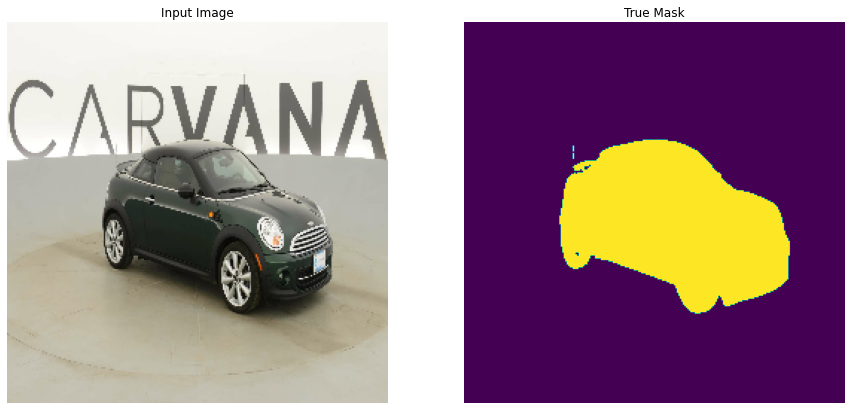

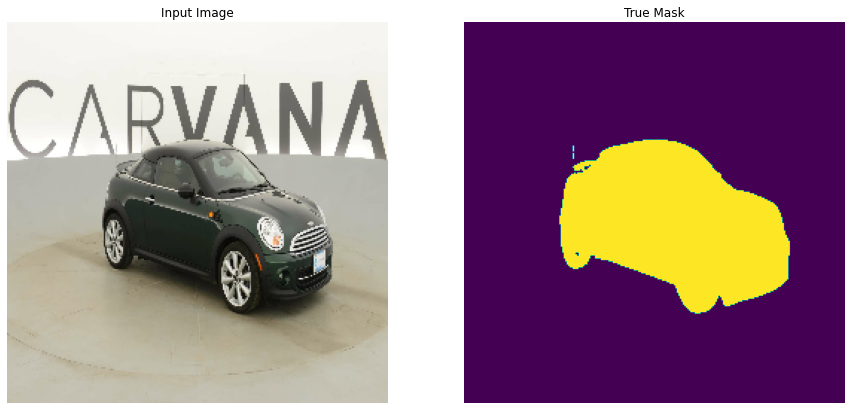

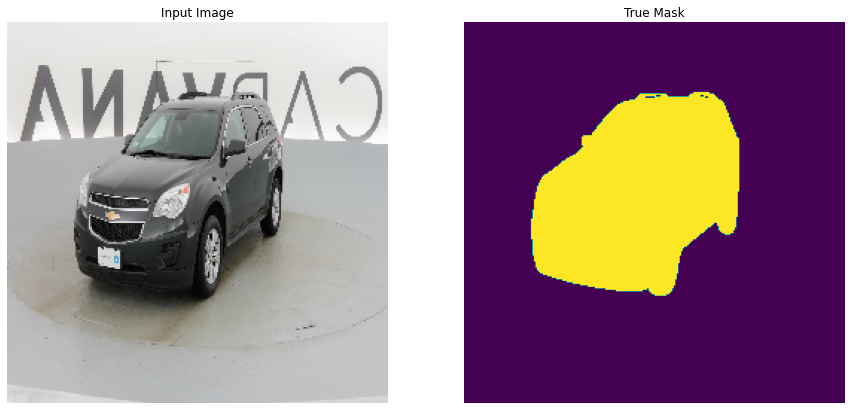

In [ ]:
for i in range(3):
   for image, mask in train.take(i):
        sample_image, sample_mask = image, mask
        visualize([sample_image, sample_mask])

## U-Net implementation

Сначала попробуем собрать свою имплементацию unet'a

<div>
<img src="https://miro.medium.com/max/1400/1*1Q3ODFV_t2WVXvm_09ExjA.png" alt="Drawing" width="600"/>
</div>

In [ ]:
K.clear_session()
model = custom_unet_model(256, 256)

model.compile(optimizer=Adam(learning_rate=0.0015),
              loss = dice_loss,
              metrics=[dice_coef, 'binary_accuracy'])

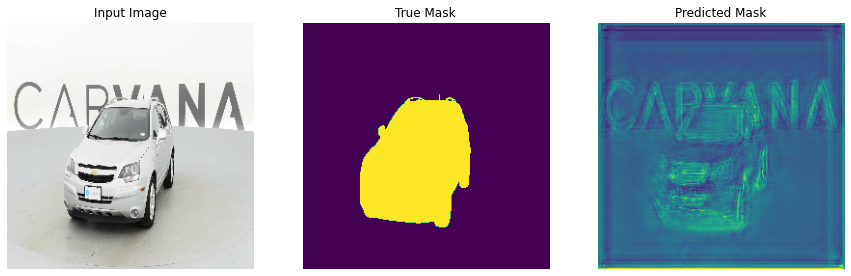

In [ ]:
# before training
for images, masks in train_dataset.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break

show_predictions(sample_image, sample_mask)

Epoch 1/10
238/238 [==============================] - 47s 191ms/step - loss: 0.2864 - dice_coef: 0.7136 - binary_accuracy: 0.8096 - val_loss: 0.0950 - val_dice_coef: 0.9050 - val_binary_accuracy: 0.9596
Epoch 2/10


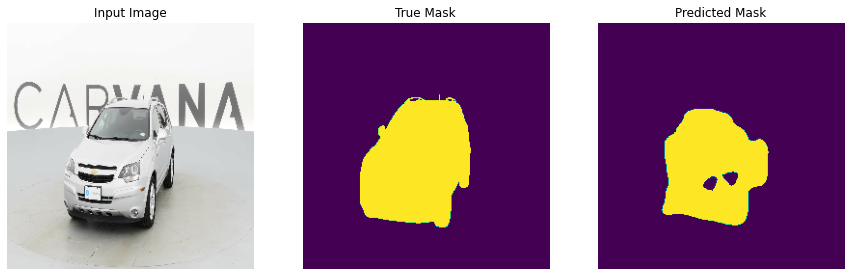

238/238 [==============================] - 45s 190ms/step - loss: 0.0600 - dice_coef: 0.9398 - binary_accuracy: 0.9751 - val_loss: 0.0432 - val_dice_coef: 0.9568 - val_binary_accuracy: 0.9823
Epoch 3/10
238/238 [==============================] - 45s 190ms/step - loss: 0.0255 - dice_coef: 0.9745 - binary_accuracy: 0.9893 - val_loss: 0.0190 - val_dice_coef: 0.9809 - val_binary_accuracy: 0.9918
Epoch 4/10


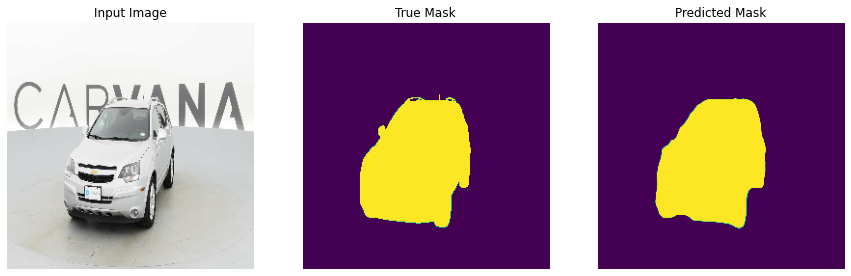

238/238 [==============================] - 45s 190ms/step - loss: 0.0167 - dice_coef: 0.9833 - binary_accuracy: 0.9930 - val_loss: 0.0240 - val_dice_coef: 0.9759 - val_binary_accuracy: 0.9894
Epoch 5/10
238/238 [==============================] - 45s 190ms/step - loss: 0.0132 - dice_coef: 0.9868 - binary_accuracy: 0.9945 - val_loss: 0.0150 - val_dice_coef: 0.9850 - val_binary_accuracy: 0.9936
Epoch 6/10


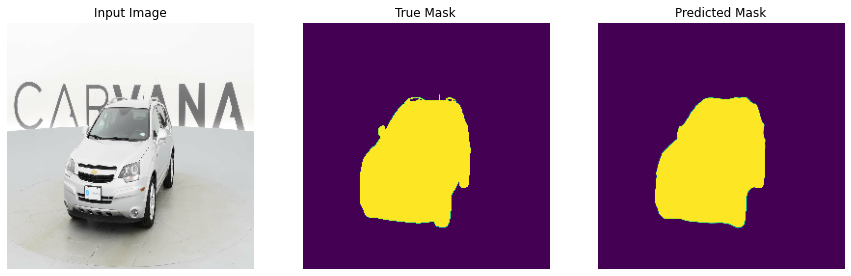

238/238 [==============================] - 45s 190ms/step - loss: 0.0115 - dice_coef: 0.9885 - binary_accuracy: 0.9952 - val_loss: 0.0119 - val_dice_coef: 0.9881 - val_binary_accuracy: 0.9949
Epoch 7/10
238/238 [==============================] - 46s 193ms/step - loss: 0.0102 - dice_coef: 0.9898 - binary_accuracy: 0.9957 - val_loss: 0.0104 - val_dice_coef: 0.9896 - val_binary_accuracy: 0.9955
Epoch 8/10


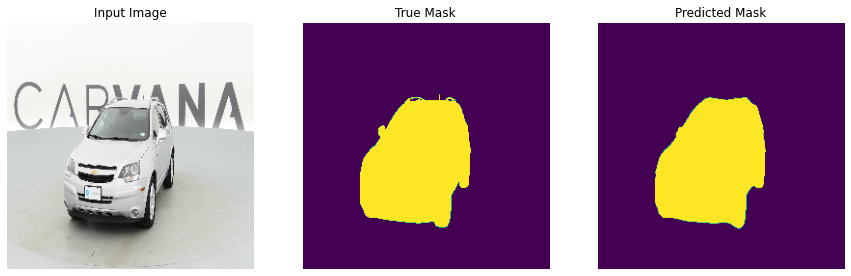

238/238 [==============================] - 46s 190ms/step - loss: 0.0093 - dice_coef: 0.9907 - binary_accuracy: 0.9961 - val_loss: 0.0093 - val_dice_coef: 0.9907 - val_binary_accuracy: 0.9960
Epoch 9/10
238/238 [==============================] - 46s 193ms/step - loss: 0.0143 - dice_coef: 0.9857 - binary_accuracy: 0.9940 - val_loss: 0.0096 - val_dice_coef: 0.9904 - val_binary_accuracy: 0.9959
Epoch 10/10


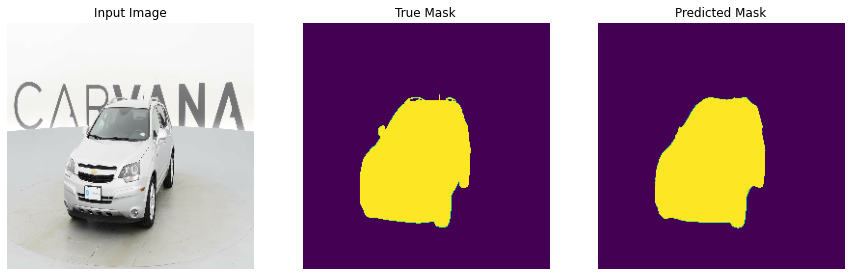

238/238 [==============================] - 46s 192ms/step - loss: 0.0092 - dice_coef: 0.9908 - binary_accuracy: 0.9962 - val_loss: 0.0088 - val_dice_coef: 0.9912 - val_binary_accuracy: 0.9963


In [ ]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)
display_cb = DisplayCallback()


EPOCHS = 10
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=[display_cb, early_stop_cb])

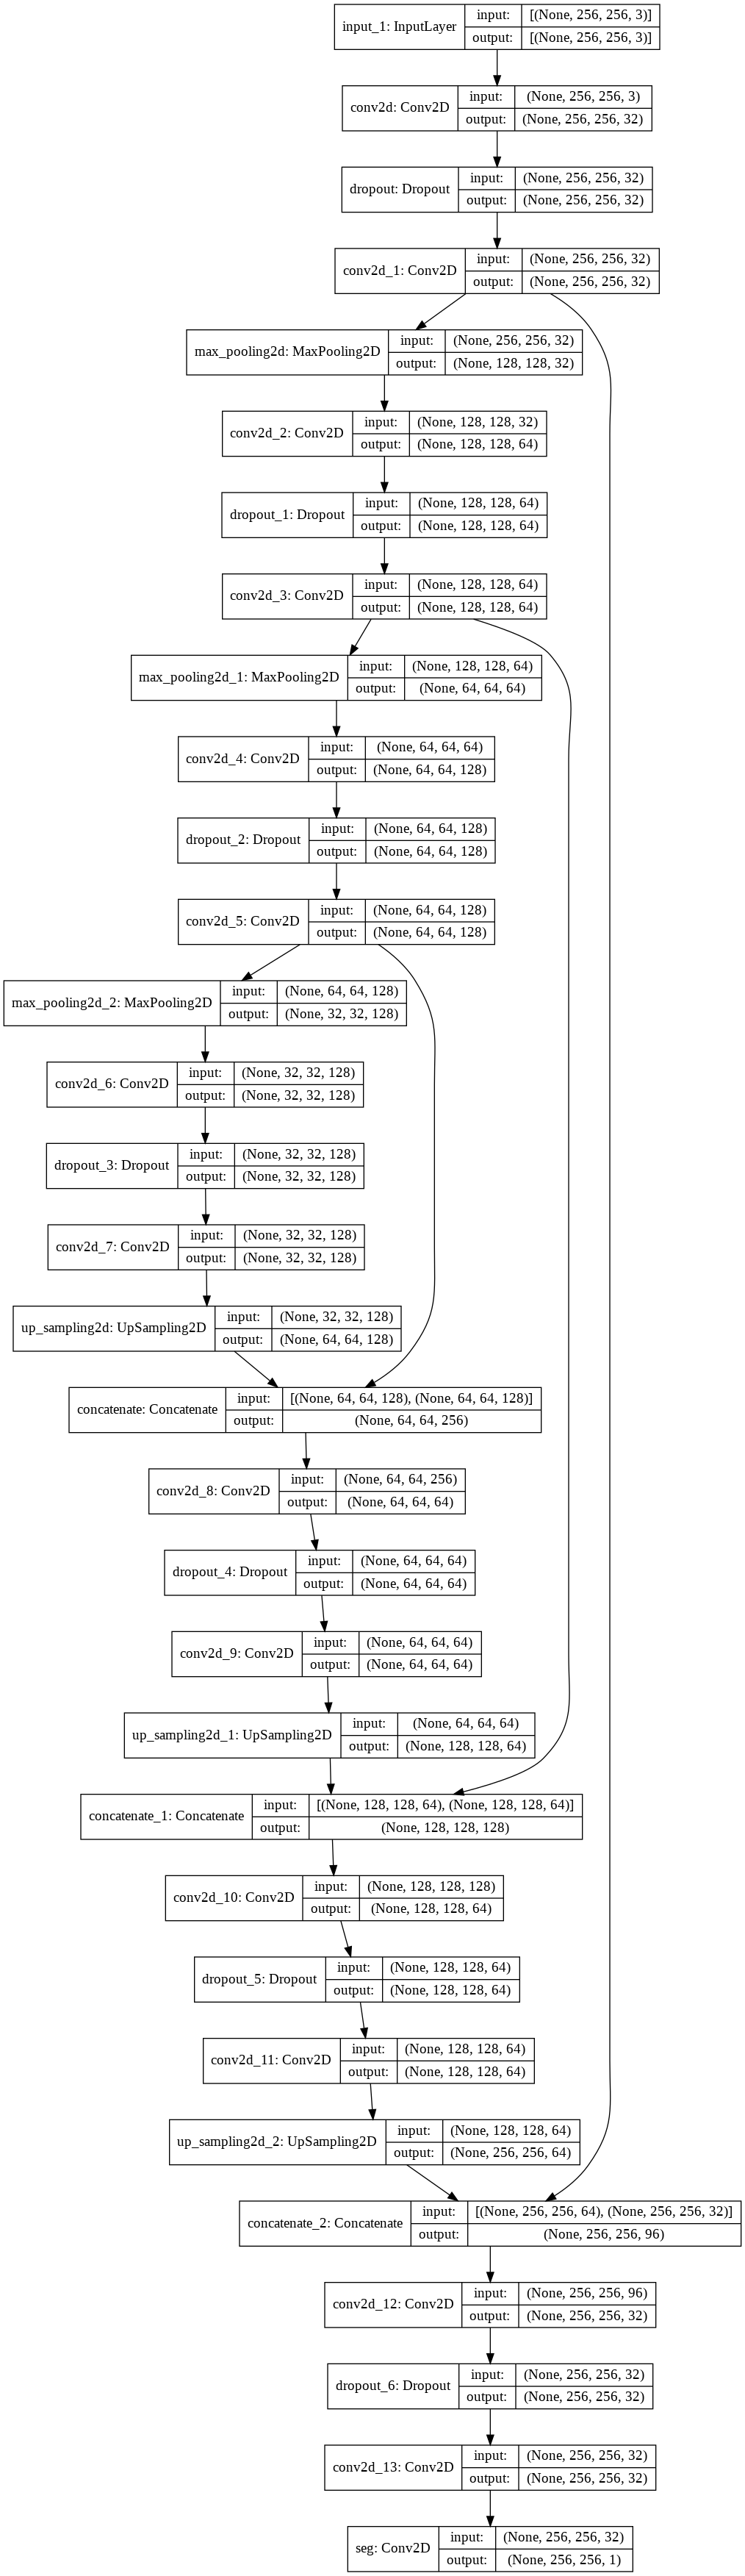

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

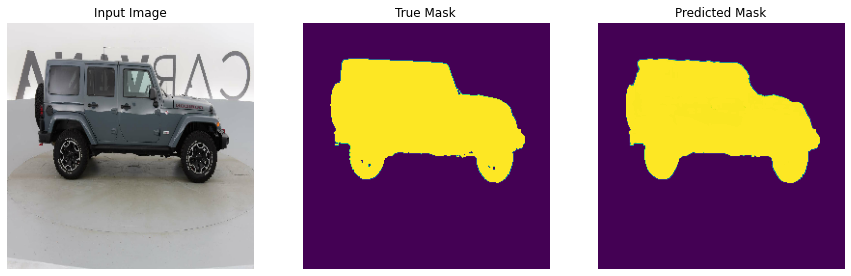

In [ ]:
for images, masks in train_dataset.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break

show_predictions(sample_image, sample_mask)

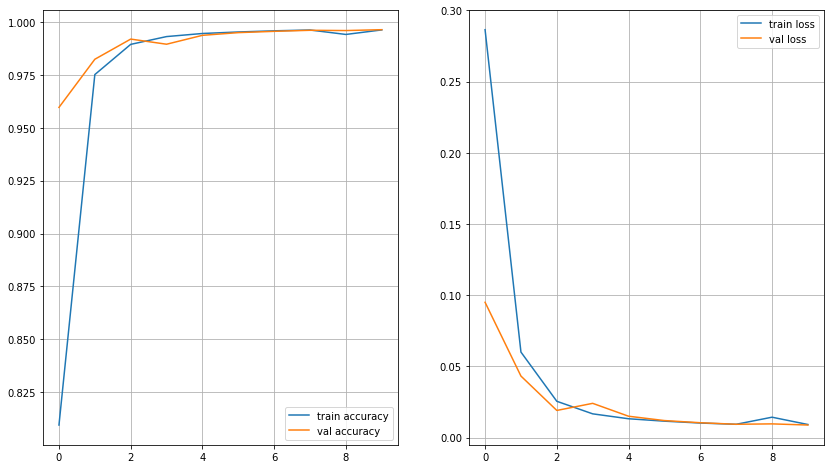

In [ ]:
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.plot(model_history.history['binary_accuracy'], label='train accuracy')
plt.plot(model_history.history['val_binary_accuracy'], label='val accuracy')
plt.legend(loc='lower right')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='val loss');
plt.legend(loc='upper right')
plt.grid()

**Обучилась хорошо, благодаря несложному датасету. Но достаточно часто сеть застревала в локальном минимуме и выдавала просто цвет фона. Решалось перезапуском сети и подгонкой гиперпараметров оптимизатора**

___

Теперь попробуем обучить гибридную сеть на основе предобученой

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

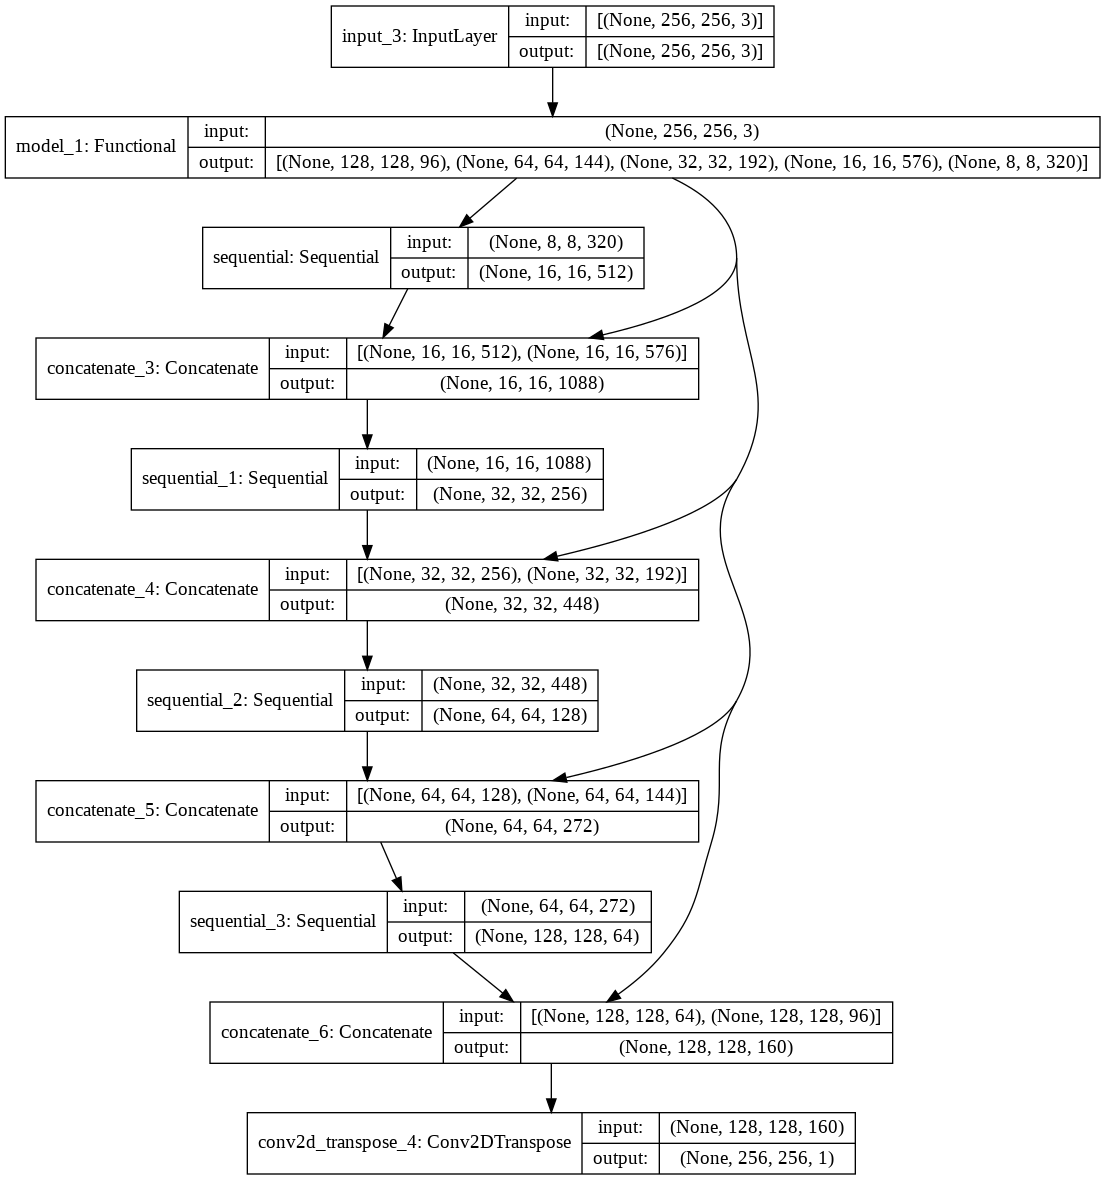

In [ ]:
model = unet_model(1)

model.compile(optimizer='adam',
              loss = dice_loss,
              metrics=[dice_coef,'binary_accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

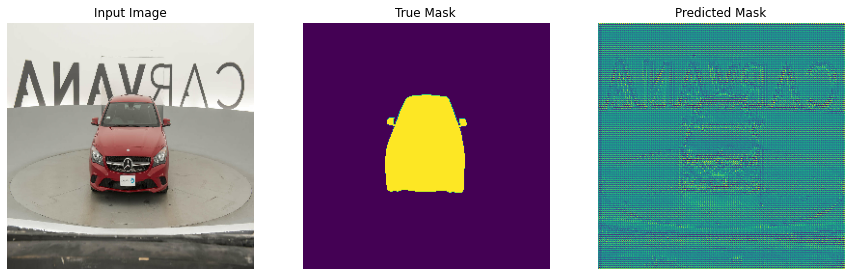

In [ ]:
# before training
for images, masks in train_dataset.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break

show_predictions(sample_image, sample_mask)

Epoch 1/10
238/238 [==============================] - 36s 136ms/step - loss: 0.0658 - dice_coef: 0.9342 - binary_accuracy: 0.9759 - val_loss: 0.0293 - val_dice_coef: 0.9707 - val_binary_accuracy: 0.9900
Epoch 2/10


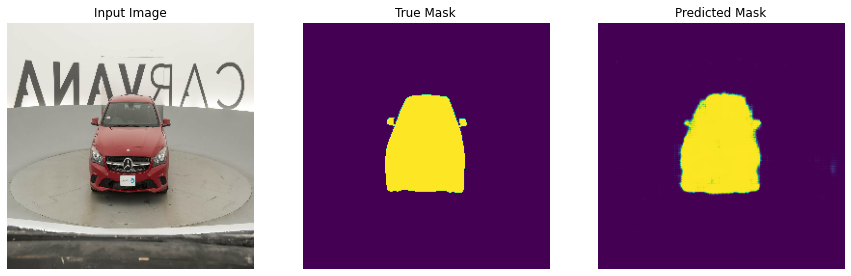

238/238 [==============================] - 32s 131ms/step - loss: 0.0239 - dice_coef: 0.9761 - binary_accuracy: 0.9913 - val_loss: 0.0249 - val_dice_coef: 0.9751 - val_binary_accuracy: 0.9906
Epoch 3/10
238/238 [==============================] - 31s 132ms/step - loss: 0.0213 - dice_coef: 0.9787 - binary_accuracy: 0.9919 - val_loss: 0.0212 - val_dice_coef: 0.9787 - val_binary_accuracy: 0.9917
Epoch 4/10


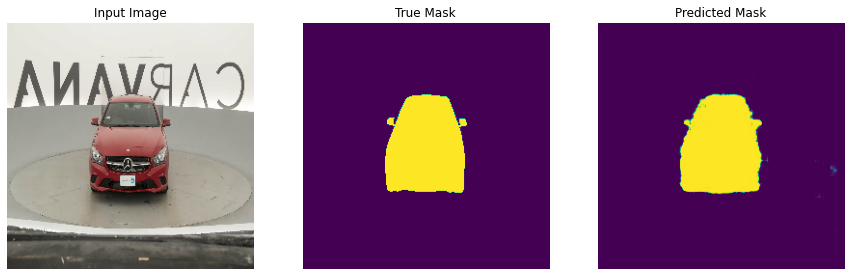

238/238 [==============================] - 32s 132ms/step - loss: 0.0199 - dice_coef: 0.9801 - binary_accuracy: 0.9923 - val_loss: 0.0200 - val_dice_coef: 0.9800 - val_binary_accuracy: 0.9920
Epoch 5/10
238/238 [==============================] - 31s 132ms/step - loss: 0.0192 - dice_coef: 0.9808 - binary_accuracy: 0.9925 - val_loss: 0.0194 - val_dice_coef: 0.9805 - val_binary_accuracy: 0.9921
Epoch 6/10


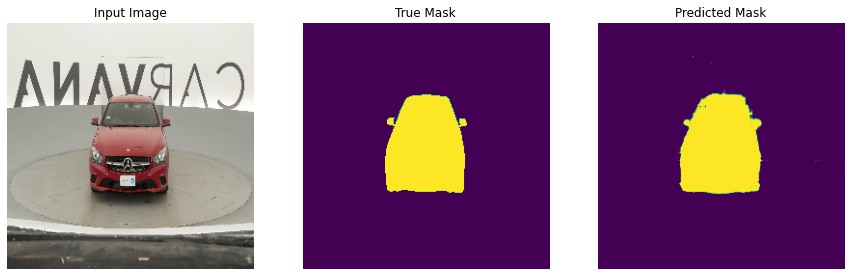

238/238 [==============================] - 32s 132ms/step - loss: 0.0186 - dice_coef: 0.9814 - binary_accuracy: 0.9926 - val_loss: 0.0197 - val_dice_coef: 0.9803 - val_binary_accuracy: 0.9919
Epoch 7/10
238/238 [==============================] - 31s 132ms/step - loss: 0.0182 - dice_coef: 0.9818 - binary_accuracy: 0.9927 - val_loss: 0.0192 - val_dice_coef: 0.9807 - val_binary_accuracy: 0.9921
Epoch 8/10


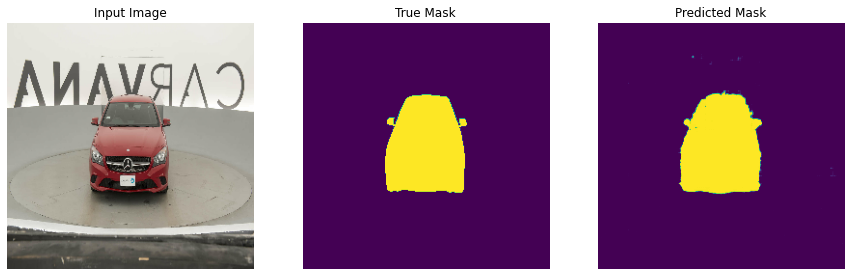

238/238 [==============================] - 31s 131ms/step - loss: 0.0179 - dice_coef: 0.9821 - binary_accuracy: 0.9928 - val_loss: 0.0190 - val_dice_coef: 0.9810 - val_binary_accuracy: 0.9921
Epoch 9/10
238/238 [==============================] - 31s 131ms/step - loss: 0.0176 - dice_coef: 0.9824 - binary_accuracy: 0.9929 - val_loss: 0.0199 - val_dice_coef: 0.9801 - val_binary_accuracy: 0.9917
Epoch 10/10


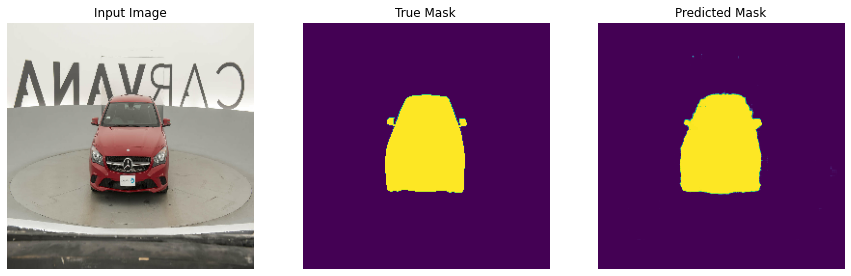

238/238 [==============================] - 31s 130ms/step - loss: 0.0174 - dice_coef: 0.9826 - binary_accuracy: 0.9930 - val_loss: 0.0184 - val_dice_coef: 0.9816 - val_binary_accuracy: 0.9923


In [ ]:
# инициализируем callback'и
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)
display_cb = DisplayCallback()


EPOCHS = 10
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=[display_cb, early_stop_cb])

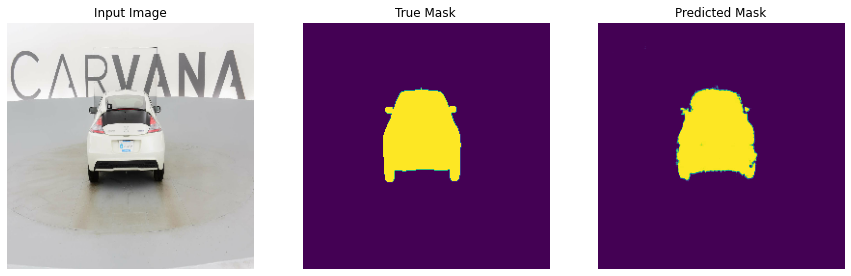

In [ ]:
for images, masks in train_dataset.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break

show_predictions(sample_image, sample_mask)

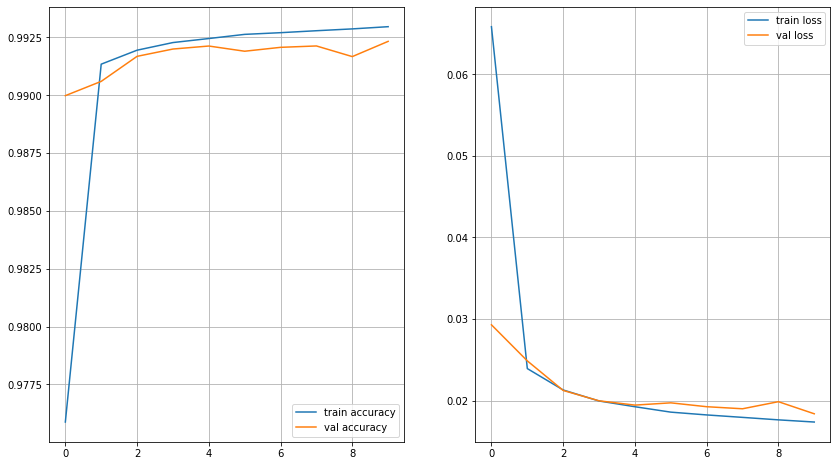

In [ ]:
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.plot(model_history.history['binary_accuracy'], label='train accuracy')
plt.plot(model_history.history['val_binary_accuracy'], label='val accuracy')
plt.legend(loc='lower right')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='val loss');
plt.legend(loc='upper right')
plt.grid()

**Результат сопоставимый, но обучалась значительно легче**